**Author**: Victor Teixidó López

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

device = 'cuda'
torch.cuda.empty_cache()

# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data from csv

We are going to read the train, validation and test data obtained in the preprocessing notebook.

In [ ]:
from datasets import Dataset, DatasetDict

# Read datasets
train_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTrainData.csv')
train_dataset = Dataset.from_pandas(train_df)

val_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedValidationData.csv')
val_dataset = Dataset.from_pandas(val_df)

test_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTestData.csv')
test_dataset = Dataset.from_pandas(test_df)

df = pd.concat([train_df, val_df, test_df])
df = df.reset_index(drop=True)

# Word frequency

In [ ]:
from collections import Counter
from wordcloud import WordCloud

def count_words(dataframe):
  words = ''.join(dataframe['reviews'])

  return Counter(words.split())

def show_word_cloud(dataframe):
  word_count = count_words(dataframe)
  wordcloud = WordCloud()
  wordcloud.generate_from_frequencies(frequencies=word_count)

  return wordcloud

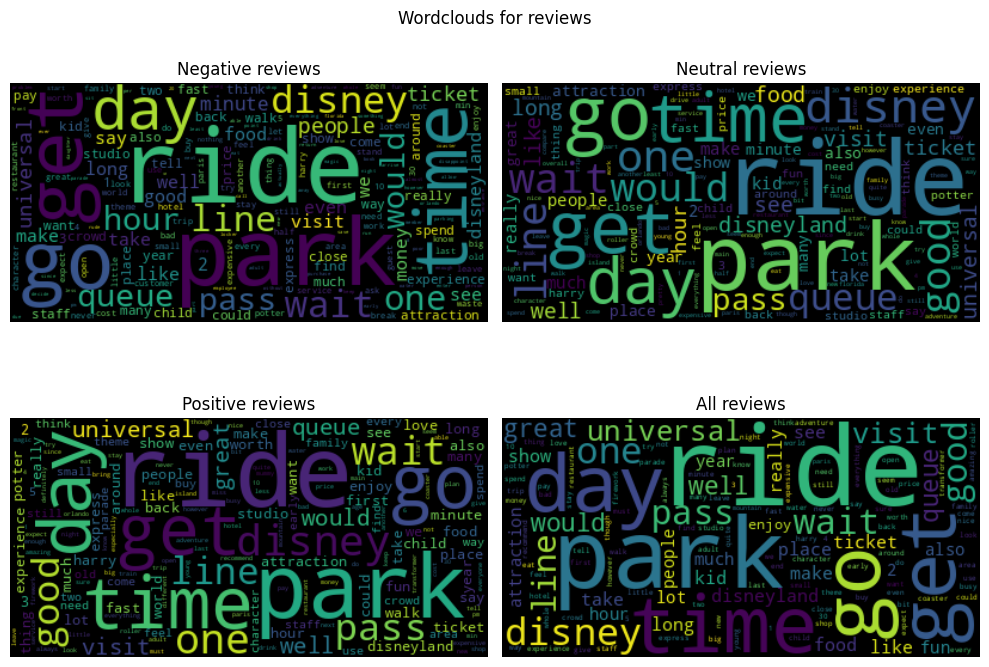

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,7.5))
axs = axs.flatten()

# Negative reviews
negative_df = df[df['ratings'] == 0]
axs[0].imshow(show_word_cloud(negative_df), interpolation='bilinear')
axs[0].set_title("Negative reviews")
axs[0].axis('off')

# Neutral reviews
neutral_df = df[df['ratings'] == 1]
axs[1].imshow(show_word_cloud(neutral_df), interpolation='bilinear')
axs[1].set_title("Neutral reviews")
axs[1].axis('off')

# Positive reviews
positive_df = df[df['ratings'] == 2]
axs[2].imshow(show_word_cloud(df), interpolation='bilinear')
axs[2].set_title("Positive reviews")
axs[2].axis('off')

# All reviews
axs[3].imshow(show_word_cloud(df), interpolation='bilinear')
axs[3].set_title("All reviews")
axs[3].axis('off')

# Show plot
plt.tight_layout()
plt.suptitle("Wordclouds for reviews")
plt.show()

# Analysis of 2-grams

In [ ]:
from collections import Counter

def get_reviews_bigrams(dataframe):
  bigrams = [b for l in dataframe['reviews'] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
  bigrams_count = Counter(bigrams)

  bigrams_df = pd.DataFrame(bigrams_count.most_common(100000), columns=['bigram', 'frequency'])

  return bigrams_df


# Get dataframes of bigrams for each class
negative_bigrams_df = get_reviews_bigrams(negative_df)
neutral_bigrams_df = get_reviews_bigrams(neutral_df)
positive_bigrams_df = get_reviews_bigrams(positive_df)

# Get dataframe of bigrams for all reviews
all_bigrams_df = get_reviews_bigrams(df)

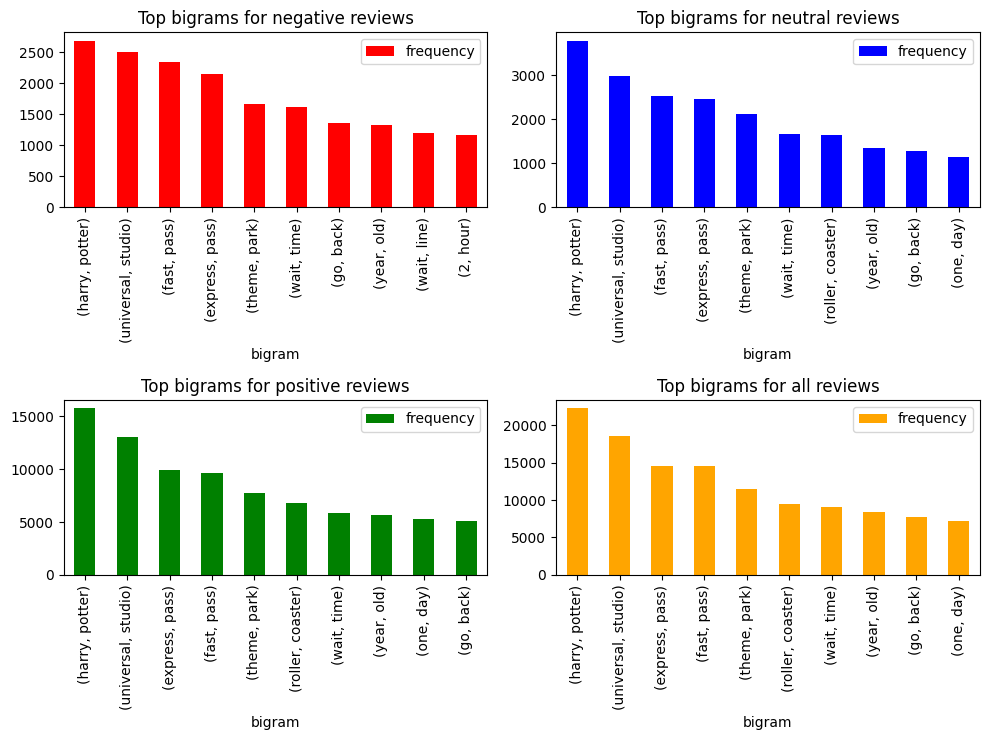

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,7.5))
axs = axs.flatten()

# Bigrams in negative reviews
negative_bigrams_df.head(10).plot(kind='bar', x='bigram', color='red', ax=axs[0])
axs[0].set_title("Top bigrams for negative reviews")


# Bigrams in neutral reviews
neutral_bigrams_df.head(10).plot(kind='bar', x='bigram', color='blue', ax=axs[1])
axs[1].set_title("Top bigrams for neutral reviews")

# Bigrams in positive reviews
positive_bigrams_df.head(10).plot(kind='bar', x='bigram', color='green', ax=axs[2])
axs[2].set_title("Top bigrams for positive reviews")

# Bigrams in all reviews
all_bigrams_df.head(10).plot(kind='bar', x='bigram', color='orange', ax=axs[3])
axs[3].set_title("Top bigrams for all reviews")

plt.tight_layout()
plt.show()

# Local Interpretable Model-Agnostic Explanationsn (LIME)

## Import tokenizer and model from pretrained

In [ ]:
hf_checkpoint = "finiteautomata/bertweet-base-sentiment-analysis"           # Hugging Face model
my_checkpoint = "/content/drive/MyDrive/UNI/tfg/models/fine_tuned_model.h5" # Hugging Face model fine-tuned

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(hf_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(my_checkpoint, num_labels=3)
model = model.to(device)

## Generate explanations

In [ ]:
import lime
from lime.lime_text import LimeTextExplainer

# Get predictions for a group of texts
def predict_proba(texts):
  inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
  inputs = {key: val.to(model.device) for key, val in inputs.items()}

  outputs = model(**inputs)

  return outputs.logits.softmax(dim=1).detach().cpu().numpy()

# Return the associated explanations for a group of texts
def generate_explanations_from_texts(texts, num_samples=10):
  explainer = LimeTextExplainer()

  explanations = []
  for idx, text in enumerate(texts):
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=10,
        labels=[0, 1, 2],
        top_labels=1,
        num_samples=num_samples
    )
    explanations.append(explanation)

    if idx % 5000 == 0 and idx != 0:
      print(f"Progress: {idx} of {len(texts)}")

  return explanations

In [ ]:
all_explanations = generate_explanations_from_texts(test_df['reviews'], num_samples=50)

Progress: 5000 of 18708
Progress: 10000 of 18708
Progress: 15000 of 18708


### Some examples

In [ ]:
# Negative review explanation
all_explanations[13].show_in_notebook()

In [ ]:
# Neutral review explanation
all_explanations[5].show_in_notebook()

In [ ]:
# Positive review explanation
all_explanations[17].show_in_notebook()

## Visualize sentiments

In [ ]:
# Given an explanation, returns for each words it's coefficient
def get_coef_from_explanation(exp: lime.explanation.Explanation):
  top_label = exp.top_labels[0]

  exp_dm = exp.domain_mapper
  exp_map = exp.as_map()[top_label]

  exp_coef = exp_dm.map_exp_ids(exp_map)
  return exp_coef


# Returns a dictionary that has for each word (with positive coef) how many times appears
def get_decisive_words(explanations):
  coef_words = {}  # Words with positive impact (positive coef)

  for explanation in explanations:
    # Get the coefficients and features (words)
    coefficients = get_coef_from_explanation(explanation)

    for word, coef in coefficients:
      if coef > 0:
        if word not in coef_words:
          coef_words[word] = 1
        else:
          coef_words[word] += 1

  # Sort decisive words by their influence
  coef_words = sorted(coef_words.items(), key=lambda x: x[1], reverse=True)
  return coef_words

### Get decisive words for reviews

In [ ]:
# Relevant words in negative reviews
negative_exp = [exp for exp in all_explanations if exp.top_labels[0] == 0]
decisive_words_neg_exp = get_decisive_words(negative_exp)
decisive_words_neg_exp = dict(decisive_words_neg_exp)

# Relevant words in neutral reviews
neutral_exp = [exp for exp in all_explanations if exp.top_labels[0] == 1]
decisive_words_neu_exp = get_decisive_words(neutral_exp)
decisive_words_neu_exp = dict(decisive_words_neu_exp)

# Relevant words in positive reviews
positive_exp = [exp for exp in all_explanations if exp.top_labels[0] == 2]
decisive_words_pos_exp = get_decisive_words(positive_exp)
decisive_words_pos_exp = dict(decisive_words_pos_exp)

### Functions to show sentiments

In [ ]:
# Given words in each class and list of domain words, returns the frequency in each type of reviews (Neg, Neu and Pos)
def get_words_freq(neg_words, neu_words, pos_words, domain_words):
  neg_freq = []
  neu_freq = []
  pos_freq = []

  for word in domain_words:
    # Save negative frequency
    word_counts = neg_words[word]
    neg_freq.append(word_counts/len(negative_exp))

    # Save neutral frequency
    word_counts = neu_words[word]
    neu_freq.append(word_counts/len(neutral_exp))

    # Save positive frequency
    word_counts = pos_words[word]
    pos_freq.append(word_counts/len(positive_exp))

  return neg_freq, neu_freq, pos_freq


# Given ratios and words show the general sentiment for each word
def plot_sentiment_for_words(neg_freq, neu_freq, pos_freq, words):
  # Create an array of positions for the words
  x = np.arange(len(words))

  # Plotting
  fig, ax = plt.subplots(figsize=(20, 6))

  bar_width = 0.2
  opacity = 0.8

  # Plotting each set of values for the words
  rects1 = plt.bar(x, neg_freq, bar_width, alpha=opacity, color='red', label='Negative')
  rects2 = plt.bar(x + bar_width, neu_freq, bar_width, alpha=opacity, color='orange', label='Neutral')
  rects3 = plt.bar(x + 2 * bar_width, pos_freq, bar_width, alpha=opacity, color='green', label='Positive')

  plt.xlabel('Domain words')
  plt.ylabel('Values')
  plt.title('Sentiment for each domain word')
  plt.xticks(x + bar_width, words)
  plt.legend()

  plt.tight_layout()
  plt.show()

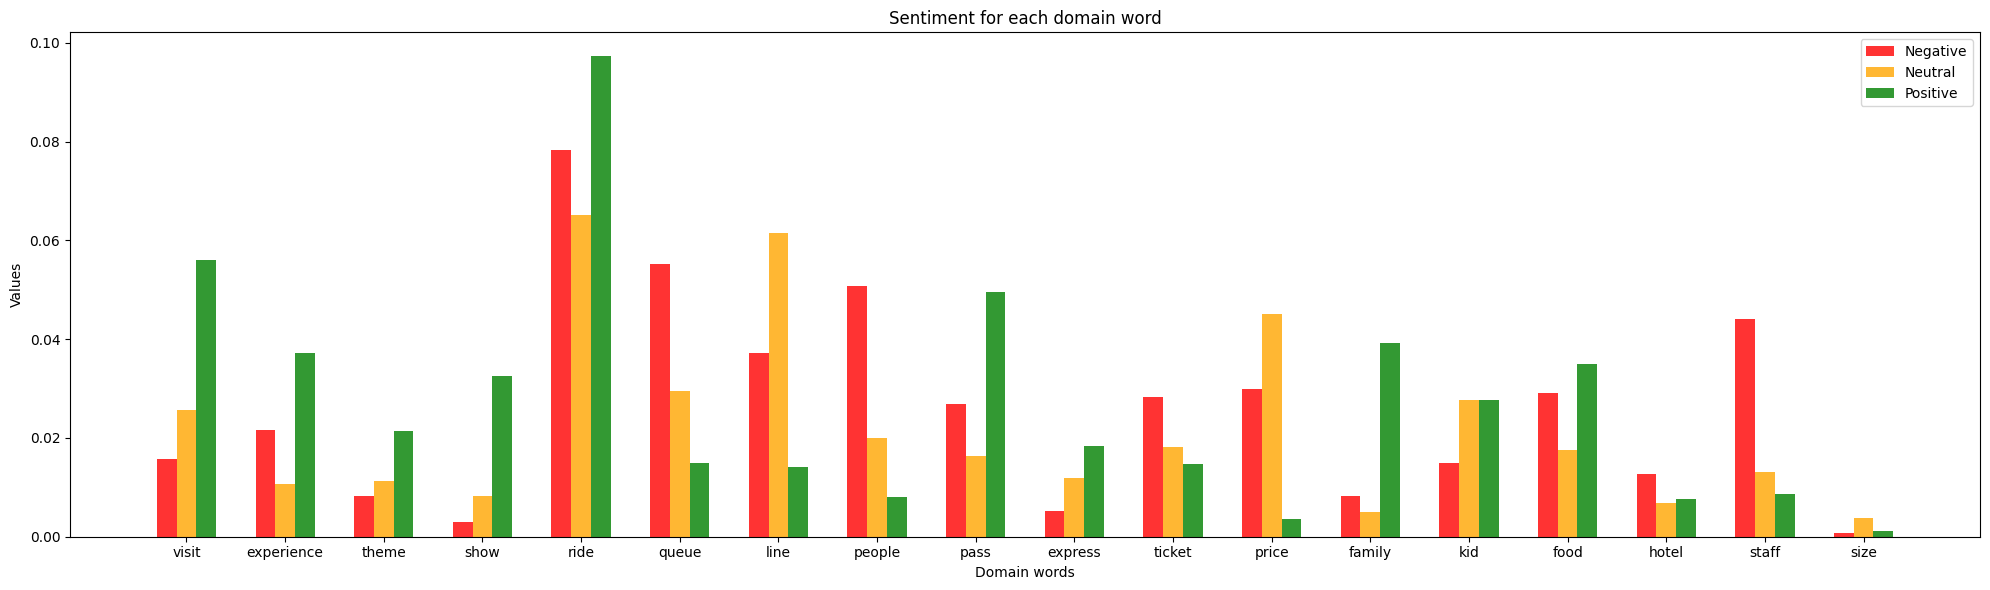

In [ ]:
# Domain words we are interested of knowing it's sentiment
domain_words = [
    'visit', 'experience', 'theme', 'show',
    'ride', 'queue', 'line', 'people', 'pass', 'express',
    'ticket', 'price',
    'family', 'kid', 'food', 'hotel', 'staff', 'size'
]


neg_freq, neu_freq, pos_freq = get_words_freq(decisive_words_neg_exp, decisive_words_neu_exp,
                                              decisive_words_pos_exp, domain_words)


# Show the sentiments associated to each word
plot_sentiment_for_words(neg_freq, neu_freq, pos_freq, domain_words)

### More relevant words by sentiment

In [ ]:
sentiment_max_freq = np.argmax([neg_freq, neu_freq, pos_freq], axis=0)
sentiment_words = {0: [], 1: [], 2: []}

for idx, word in enumerate(domain_words):
    max_freq = sentiment_max_freq[idx]
    sentiment_words[max_freq].append(word)


sentiments = {0: "Negative", 1: "Neutral", 2: "Positive"}
for key, value in sentiment_words.items():
  print(f"Most frequent domain words in {sentiments[key]} reviews: {value}")

Most frequent domain words in Negative reviews: ['queue', 'people', 'ticket', 'hotel', 'staff']
Most frequent domain words in Neutral reviews: ['line', 'price', 'size']
Most frequent domain words in Positive reviews: ['visit', 'experience', 'theme', 'show', 'ride', 'pass', 'express', 'family', 'kid', 'food']
